<font size=7> Latencies Analysis

# Get Pairs <font color="green"> Randomize Data

In [1]:
from human_hip.spike_data import random_harris, random_shuffle, random_rotation

In [2]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, read_phy_files,\
                                  plot_latency_dist_hist, plot_latency_angle_hist, latency_times, plot_vector_layout5, plot_vector_layout1,\
                                   arrow_check, arrow_check2
from human_hip.animate import animate_latencies
from ipywidgets import interact_manual, interact
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
with open("/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/sd_ca1_curated.pkl", "rb") as filename:
    sd = pickle.load(filename)

In [4]:
sd = (sd)

In [5]:
import numpy as np
from human_hip.spike_data import latencies, cross_sttc

(-0.1, 0.2)

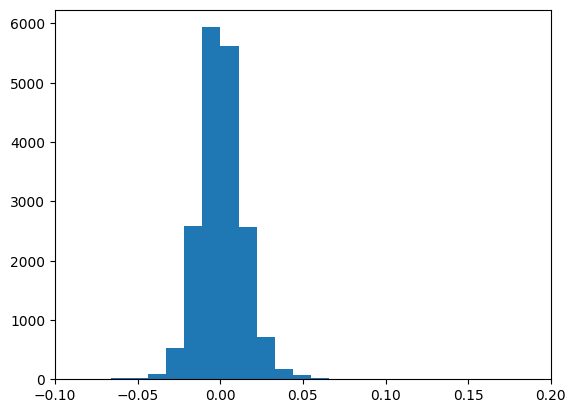

In [6]:
sttc_neo = sd.spike_time_tilings( 20 ) 
plt.hist( sttc_neo.flatten(), bins=100 )
plt.xlim(-.1,.2)


In [7]:

import numpy as np
from human_hip.spike_data import latencies, cross_sttc


def curate_latencies(sd,  latency_ms=30, sttc_cutoff = 0, latency_cutoff=1, sttc_delta=20, pval=.05, min_latencies=25 ):

    # Get all latencies whose STTC is above some minimum STTC cuttoff
    print(sd.N**2 , "Starting Pairs")
    sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
    pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
    for i in range(sd.N):
        for j in range(i+1,sd.N):
            if sttc_neo[i,j] > sttc_cutoff:
                pairs.append([i,j])
    print( len(pairs), "pairs above sttc cutoff")

    # Get all latencies whose median latency is above some minimum Latency Cuttoff
    pairs_late = [] #lags_late = []
    for pair in pairs:
        pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=latency_ms)  #latency= np.median(pair_latencies)
        if len(pair_latencies)>=min_latencies and abs(np.mean(pair_latencies))> latency_cutoff :
            if np.mean(pair_latencies) < 0:
                pair_latencies = latencies( pair[1], pair[0], sd, ms_cutoff_high=latency_ms) 
                if np.mean(pair_latencies)> latency_cutoff and len(pair_latencies)>=min_latencies:
                    t_stat, p_value = stats.ttest_1samp( pair_latencies, 0)
                    if p_value < pval:
                        pairs_late.append( [ pair[1], pair[0] ] )
            else:
                t_stat, p_value = stats.ttest_1samp( pair_latencies, 0)
                if p_value < pval:
                    pairs_late.append( pair )
    print( len(pairs_late), "pairs above latencency cutoff")

    mean_latencies = []
    for pair in pairs_late:
        mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=latency_ms)  )
        mean_latencies.append(mean_latency)
    print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))
    #good_pairs =   np.array(pairs_final)

    return  pairs_late

In [14]:
latency_ms = 30
good_pairs = curate_latencies(sd, latency_ms=30, sttc_cutoff = 0.01, latency_cutoff=1, sttc_delta=20, pval=.05, min_latencies=25 ) 

# latency_ms = 15
# good_pairs = curate_latencies(sd,  latency_ms=latency_ms, sttc_cutoff = 0.02, latency_cutoff=1, sttc_delta=20, pval=.05 ) 

good_pairs2 = np.array(good_pairs)


# with open( 'hc328_good_pairs.pkl' , 'wb') as my_file:
#    pickle.dump(good_pairs, my_file)
# load pickled data
# with open( 'hc328_good_pairs.pkl' , 'rb') as my_file:
#     good_pairs = pickle.load(my_file)

18496 Starting Pairs
1997 pairs above sttc cutoff
65 pairs above latencency cutoff
all final pairs positive?: True


In [7]:
# with open( 'hc328_good_pairs.pkl' , 'wb') as my_file:
#    pickle.dump(good_pairs, my_file)

In [15]:
#good_pairs
print( len(good_pairs), "good pairs" )

mean_latencies = []
for pair in good_pairs:
    mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=latency_ms)  )
    mean_latencies.append(mean_latency)
print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))

65 good pairs
all final pairs positive?: True


# make plots

all final pairs positive?: True


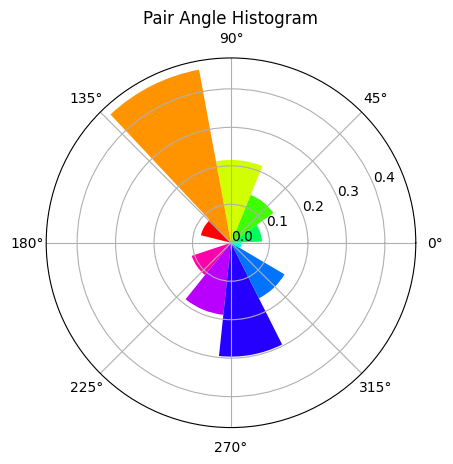

In [16]:
plot_latency_angle_hist(sd, good_pairs, late_cutoff_high=latency_ms)

all final pairs positive?: True


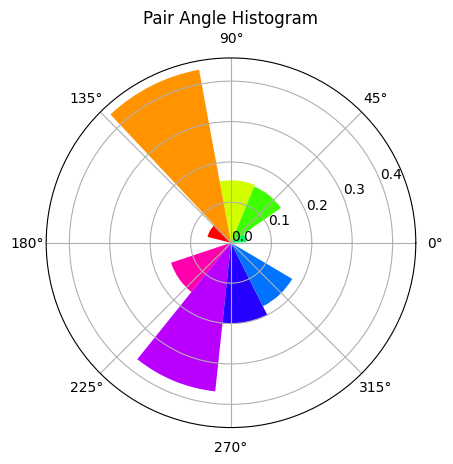

In [17]:
plot_latency_angle_hist(sd, good_pairs, by_firing_rate=True, late_cutoff_low=0, late_cutoff_high=latency_ms)

# Make Plots

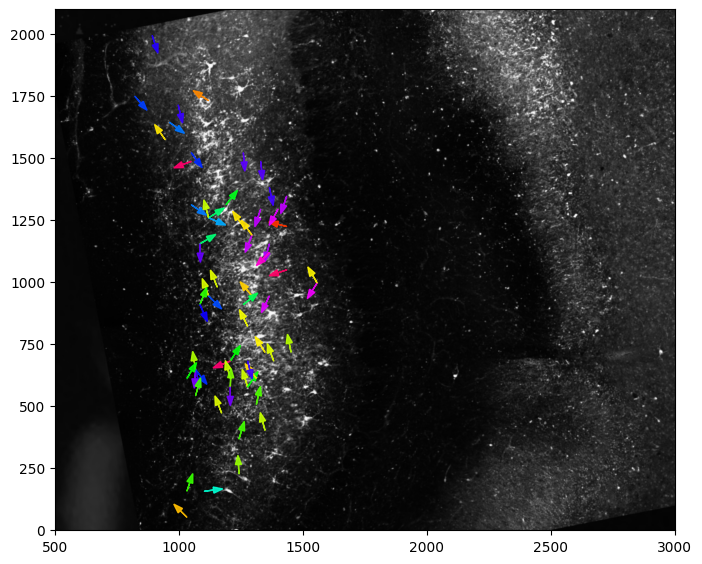

In [18]:
plot_vector_layout1( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc328_bw.jpeg", xlim=(500,3000) )

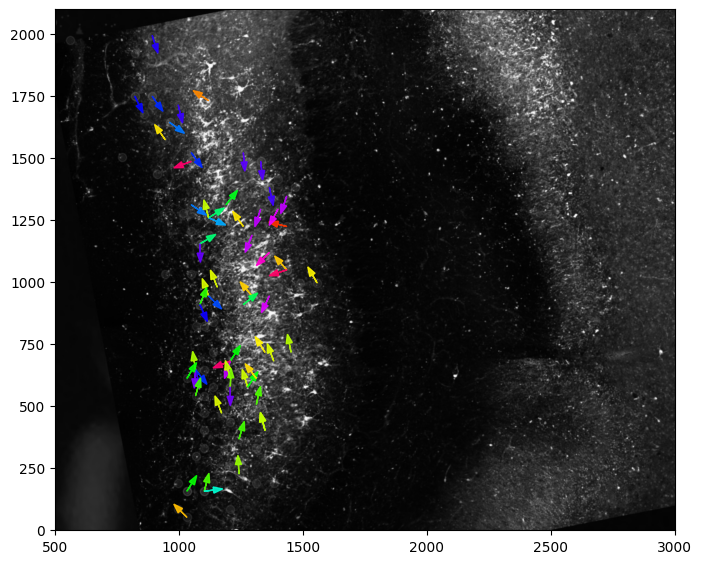

In [19]:
plot_vector_layout( sd, good_pairs2, image_path="/workspaces/human_hippocampus/data/histology/hc328_bw.jpeg", xlim=(500,3000) )

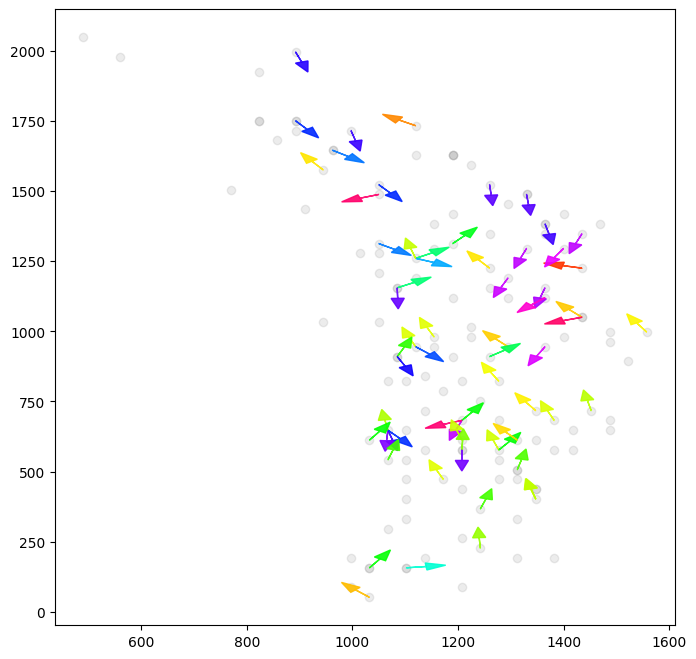

In [20]:
plot_vector_layout( sd, good_pairs2)

In [21]:
from ipywidgets import interact_manual, interact
from scipy import stats

def pairs_hisogram(good_pairs, sd, ms_cutoff_high=latency_ms ):
    @interact
    def plot_pair(pair_i = (0, len(good_pairs)-1) ):
        latencies_pair = latencies( good_pairs[pair_i][0], good_pairs[pair_i][1], sd, ms_cutoff_high=ms_cutoff_high )
        plt.xlim(-ms_cutoff_high, ms_cutoff_high)
        plt.hist(latencies_pair, bins=12)
        print("Pair: ", good_pairs[pair_i][0],good_pairs[pair_i][1] )
        print("Latency Mean:\t", np.mean(latencies_pair ) )

        t_stat, p_value = stats.ttest_1samp( latencies_pair, 0)
        one_sided_p_value = p_value / 2 if t_stat > 0 else 1 - p_value / 2
        print("T-Test 1-Side:\t", one_sided_p_value )  #print("T-Test: ", stats.ttest_1samp(latencies_pair, 0)[1] )
        
pairs_hisogram( good_pairs, sd, ms_cutoff_high=latency_ms)

interactive(children=(IntSlider(value=32, description='pair_i', max=64), Output()), _dom_classes=('widget-inte…

# Curate Arrows

Pairs removed by SD cutoff: 21


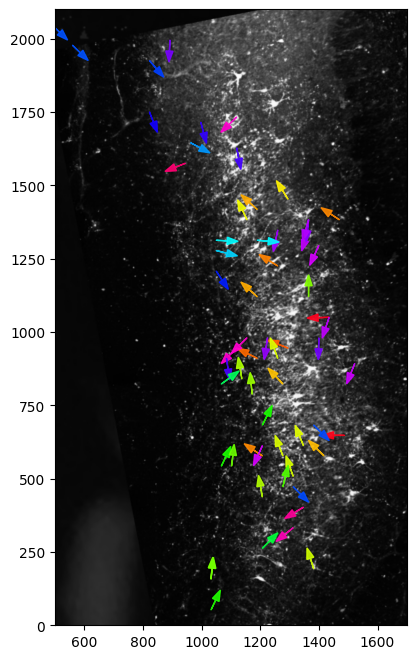

In [11]:
plot_vector_layout5( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc328_bw.jpeg",
                         figsize=(8, 12), xlim=(500,1700), #ylim=(0,1600),
                         sd_cuttoff=.5 , latency_ms=30)

Pairs removed by SD cutoff: 21


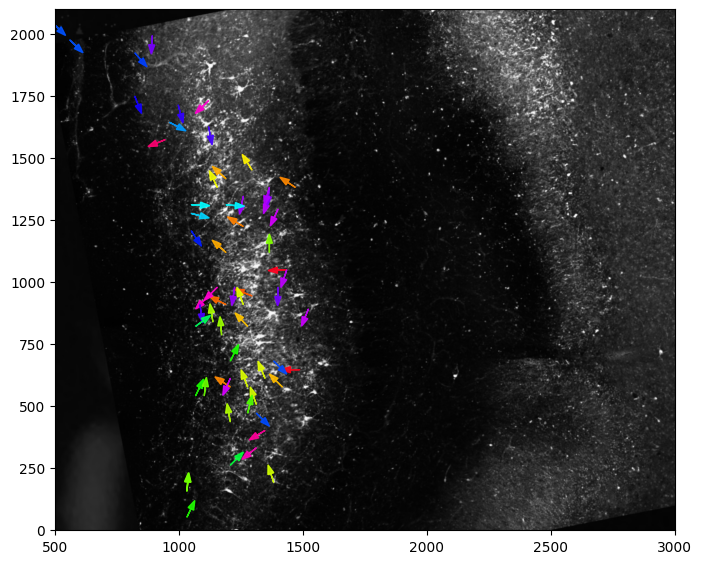

In [8]:
plot_vector_layout5( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc328_bw.jpeg",
                         figsize=(8, 8), xlim=(500,3000), #ylim=(0,1600),
                         sd_cuttoff=.5 , latency_ms=30)

Pairs removed by SD cutoff: 8


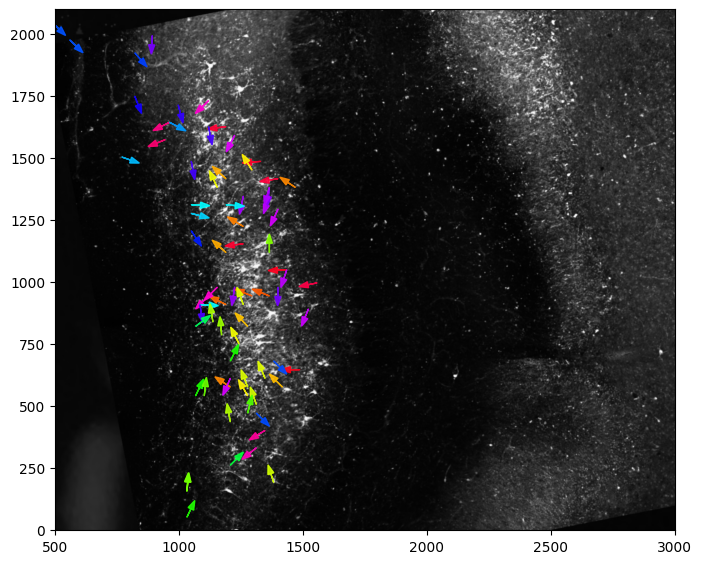

In [9]:
plot_vector_layout5( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/hc328_bw.jpeg",
                         figsize=(8, 8), xlim=(500,3000), #ylim=(0,1600),
                         sd_cuttoff=1 , latency_ms=30)

# <font color="brown"> Arrow Check

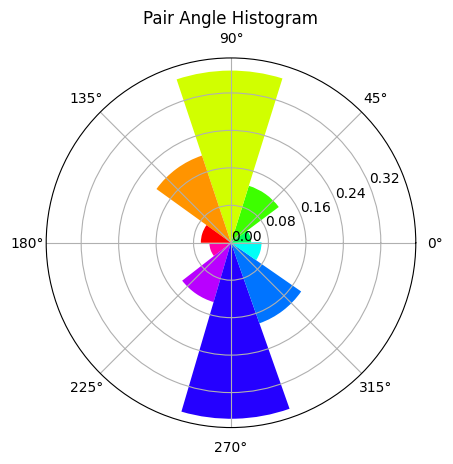

In [5]:
arrow_check2(sd)